# <center> Unit 2 - Feature Selection and Explainability
## <center> Explainable AI practical work

In this report we examined both **feature selection** methods and model **explainablility**, using a churn prediction problem.
We were most interested in the differences between the global explanations the models would provide, and the local ones, the **LIME** and **SHAP** algorithm provide, given a test sample and a fitted estimator


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, mutual_info_classif, chi2
from sklearn.ensemble import RandomForestClassifier
from matplotlib_venn import venn2

from lime import lime_tabular
import shap
import warnings

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
original_df = df.copy()

## <center> EDA

In [3]:
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.shape

(7043, 21)

In [5]:
bool_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'SeniorCitizen']

for col in bool_cols + ['Churn']:
    df.loc[df[col] == 'Yes', col] = 1
    df.loc[df[col] == 'No', col] = 0
    df[col] = df[col].astype(int)

In [6]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling      int64
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                 int64
dtype: object

In [7]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [8]:
df.describe()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,Churn
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,0.483033,0.299588,32.371149,0.903166,0.592219,64.761692,0.265370
std,0.368612,0.499748,0.458110,24.559481,0.295752,0.491457,30.090047,0.441561
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,0.000000
25%,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,35.500000,0.000000
50%,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,70.350000,0.000000
75%,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,89.850000,1.000000
max,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,118.750000,1.000000


In [9]:
df.Churn.value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

The dataset is biased much more non-churned customers than churned ones

In [10]:
df = df.drop(columns=['customerID'])
df = df.loc[df['TotalCharges'] != ' ']
df['TotalCharges'] = df.TotalCharges.astype(float)

In [11]:
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

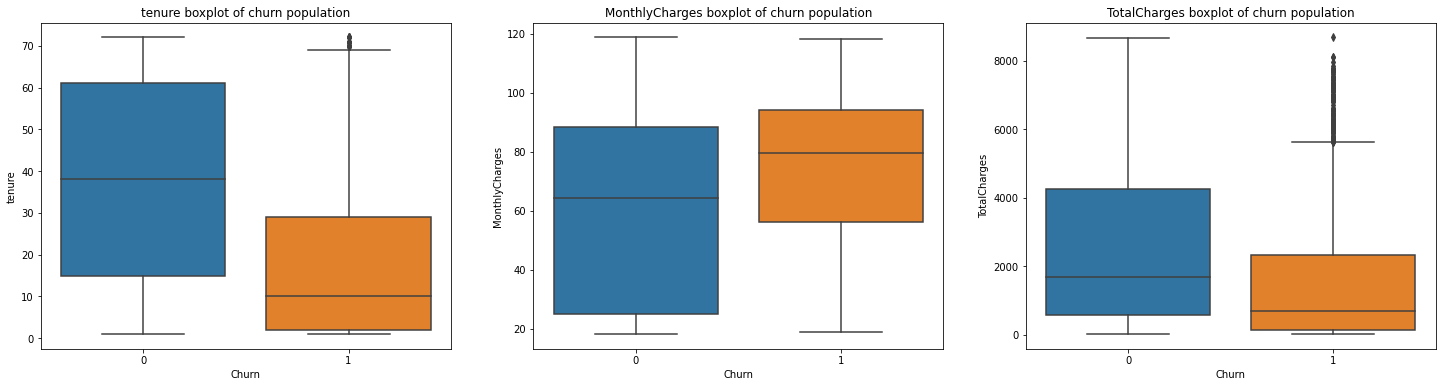

In [12]:
_, ax = plt.subplots(1, 3, figsize=(25, 6))
i = 0
for col in numeric_cols:
    sns.boxplot(x='Churn', y=col, data=df, ax=ax[i])
    ax[i].set(title=f'{col} boxplot of churn population')
    i += 1

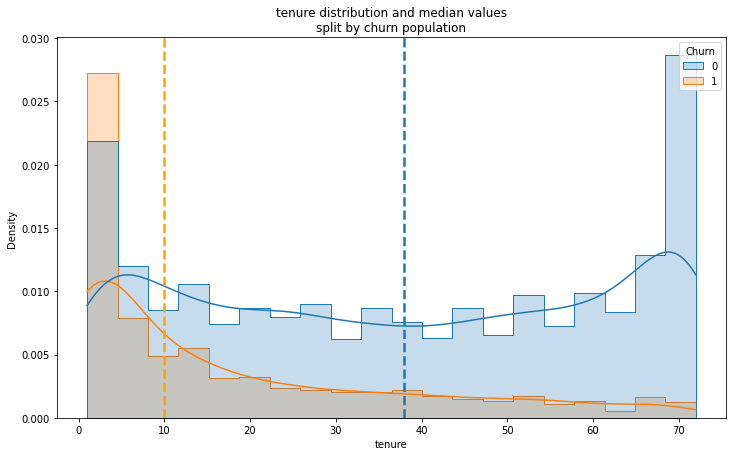

In [13]:
_, ax= plt.subplots(1,1, figsize=(12,7))
sns.histplot(data=df, x='tenure', hue='Churn', stat="density", element='step', bins=20, kde=True, ax=ax)
ax.set(title='tenure distribution and median values\nsplit by churn population')
ax.axvline(x=df.loc[df['Churn']==1, 'tenure'].median(), color='orange', ls='--', lw=2.5)
ax.axvline(x=df.loc[df['Churn']==0, 'tenure'].median(), ls='--', lw=2.5);

`tenure` seems to have a great significance for predicting churners. We will test this in a WRS test

In [14]:
churn = df.loc[df['Churn'] == 1]
non_churn = df.loc[df['Churn'] == 0]
_, p = mannwhitneyu(churn['tenure'], non_churn['tenure'], alternative='less')
print(f'p-value for H-A, where Churn population has less tenure is {p:.4}')

p-value for H-A, where Churn population has less tenure is 3.022e-211


The p-value is very low, so we understand that this difference is significant indeed

In [15]:
non_numeric_cols = [col for col in df.columns if col not in numeric_cols + ['Churn']]

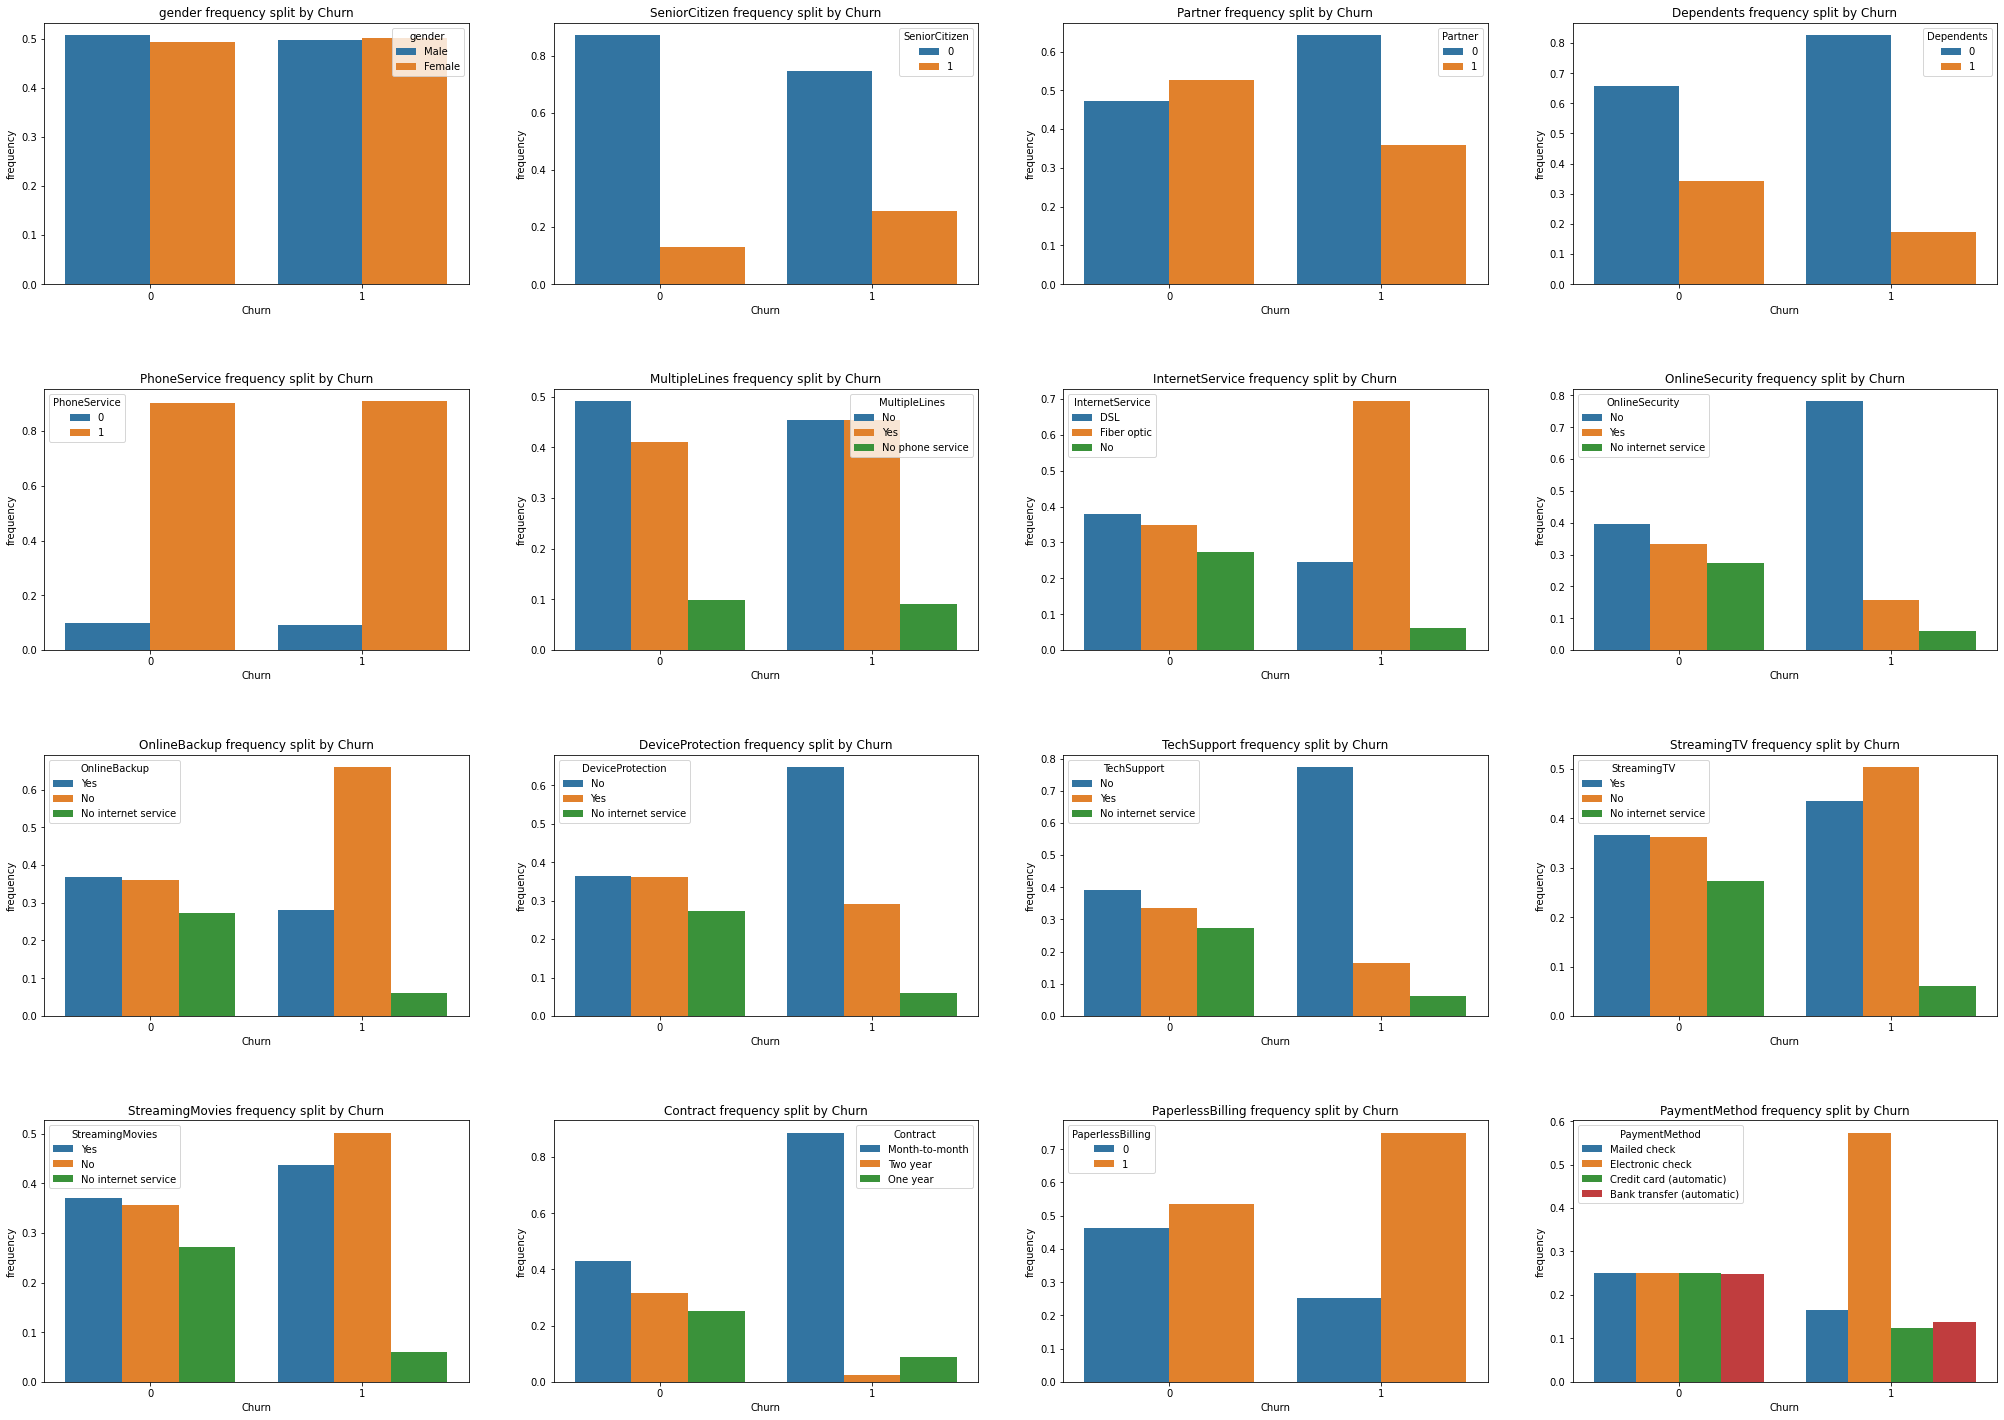

In [16]:
m = len(non_numeric_cols)
plot_col_n = 4
_, ax = plt.subplots(4, plot_col_n, figsize=(35, 25))
plt.subplots_adjust(hspace=0.4)
i = 0
for col in non_numeric_cols:
    _ax = ax[i // plot_col_n][i % plot_col_n]
    x, y = 'Churn', col
    plot_data = df.groupby(x)[y].value_counts(normalize=True).rename('frequency').reset_index()
    sns.barplot(data=plot_data, x=x, y='frequency', hue=y, ax=_ax)
    _ax.set(title=f'{col} frequency split by Churn')
    i += 1

`Contract`, `OnlineSecurity` and `TechSupport` all have differences between churner and non-churners, and seem like good candidates for training features.

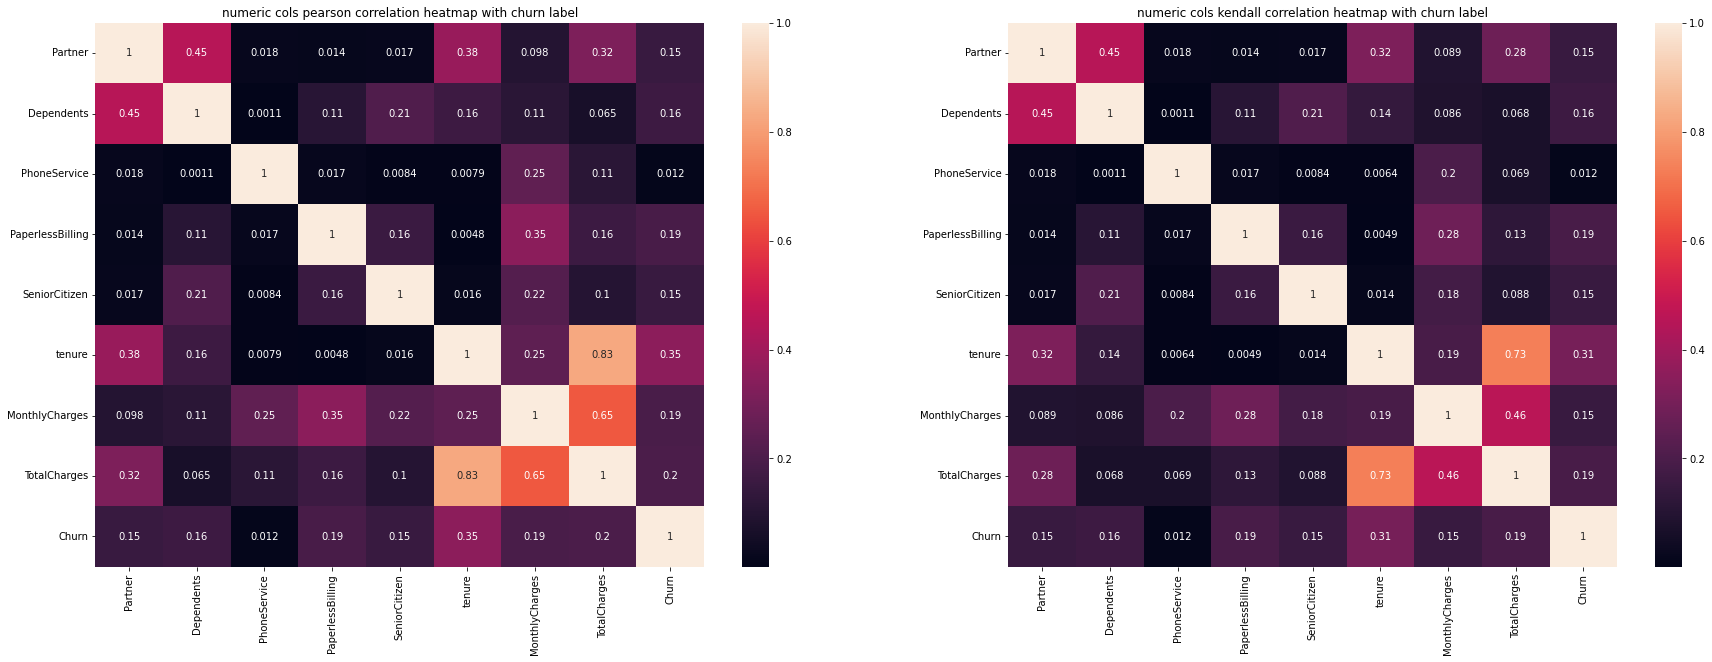

In [17]:
_, ax = plt.subplots(1, 2, figsize=(30, 10))
i = 0
for method in ['pearson', 'kendall']:
    sns.heatmap(df[bool_cols + numeric_cols + ['Churn']].corr(method=method).abs(), annot=True, ax=ax[i])
    ax[i].set(title=f'numeric cols {method} correlation heatmap with churn label')
    i += 1

As expected, we see high correlation between the `TotalCharges` column and the `tenure` and `MonthlyCharges` columns (since it is rough multiplication of the two)
So, we decide to remove `TotalCharges` from the dataset
We do see some interesting correlation between the label and the `tenure` feature, that was also evident in the boxplot we showed earlier
This might suggest that long-lasting customer are less likely to churn.
We also see a high correlation value for the `Dependants` and `Partner` columns, that also make sense. So we remove the `Partner` column
At last, `PhoneService` seems to have very low correlation to the target, so we drop that.

In [18]:
cat_cols = [col for col in df.columns if col not in bool_cols + numeric_cols + ['Churn']]
for col in cat_cols:
    df[col] = df[col].astype('category').cat.codes.astype('int8')

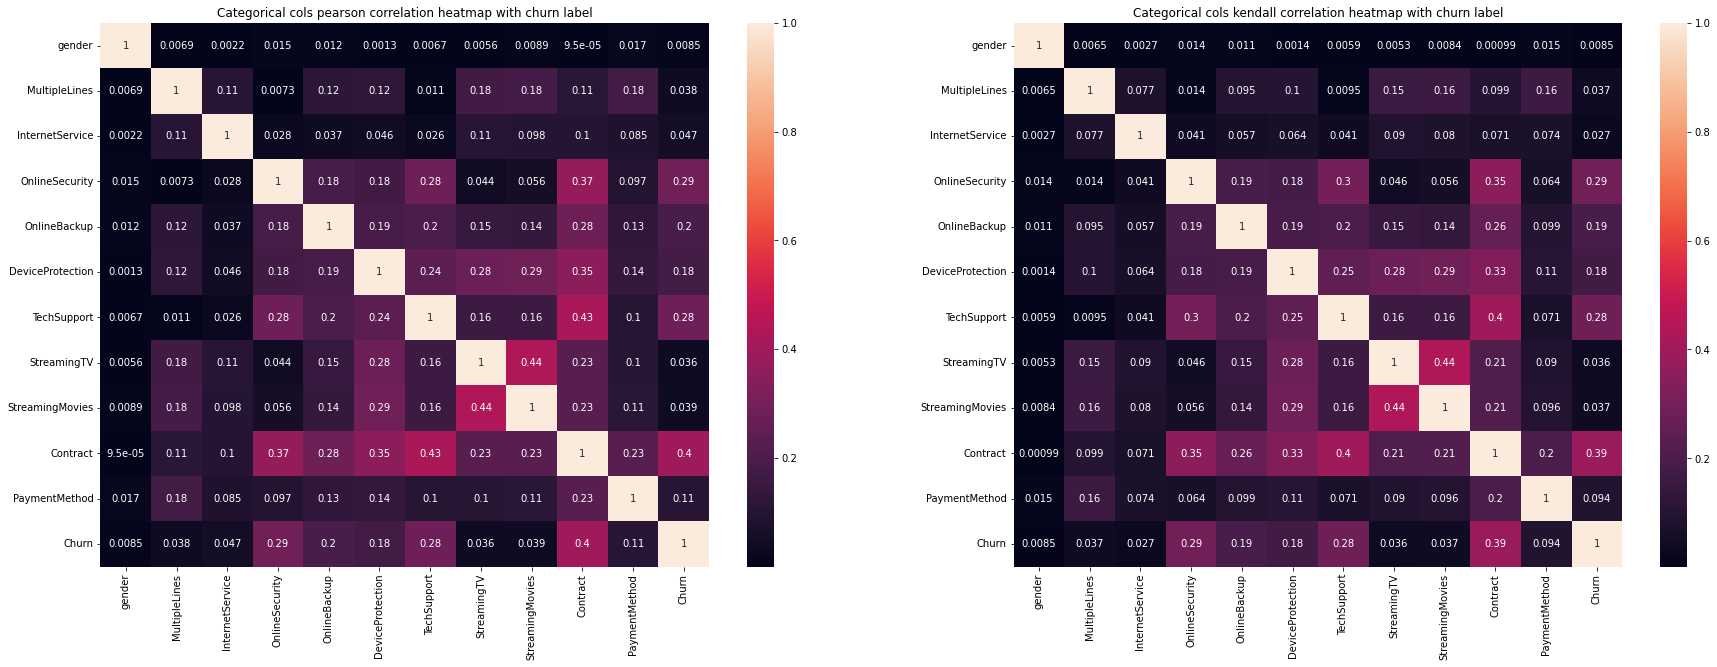

In [19]:
_, ax = plt.subplots(1, 2, figsize=(30, 10))
i = 0
for method in ['pearson', 'kendall']:
    sns.heatmap(df[cat_cols + ['Churn']].corr(method=method).abs(), annot=True, ax=ax[i])
    ax[i].set(title=f'Categorical cols {method} correlation heatmap with churn label')
    i += 1

Columns with low correlation to `Churn` we decided to drop: [`gender`, `MultipleLines`, `InternetService`, `StreamingTV`, `StreamingMovies`, `PaymentMethod`]

In [20]:
cols_to_remove = ['TotalCharges', 'Partner', 'PhoneService', 'gender', 'MultipleLines', 'InternetService',
                  'StreamingTV', 'StreamingMovies', 'PaymentMethod']
df_for_estimation = df.drop(columns=cols_to_remove)

## <center> Feature Selection

Next we run sklearn SFS (both forward and backwards) and auto filtering, and look at the differences from our manual selection:

In [21]:
RANDOM_STATE = 71
y = df['Churn']
X = df.drop(columns=['Churn'])
X_train, _, y_train, _ = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

In [22]:
def calc_SFS(X_train, y_train, estimator):
    sfs_forward = SequentialFeatureSelector(
        estimator, n_features_to_select=9, direction="forward"
    ).fit(X_train, y_train)
    sfs_backward = SequentialFeatureSelector(
        estimator, n_features_to_select=9, direction="backward"
    ).fit(X_train, y_train)
    return sfs_forward, sfs_backward

In [23]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['font.size'] = 16

def plot_selected_features(fs, df_for_estimation, SFS=True):
    A = set(X.columns[fs.get_support()])
    B = set(df_for_estimation.columns)
    venn = venn2((A, B), ('Manual Filtering', f'SFS - {fs.direction}' if SFS else f'{fs.score_func.__name__} based filtering'))
    venn.get_label_by_id('01').set_text('\n\n'.join(A-B))
    venn.get_label_by_id('10').set_text('\n\n'.join(B-A))
    venn.get_label_by_id('11').set_text('\n\n'.join(A&B))
    plt.title(f"Features selection Venn diagram by {type(fs.estimator).__name__ if SFS else 'auto filter'} estimation")
    plt.show()

#### SFS using a Logistic Regression estimator

In [24]:
sfs_forward, sfs_backward = calc_SFS(X_train, y_train, LogisticRegression(class_weight='balanced'))

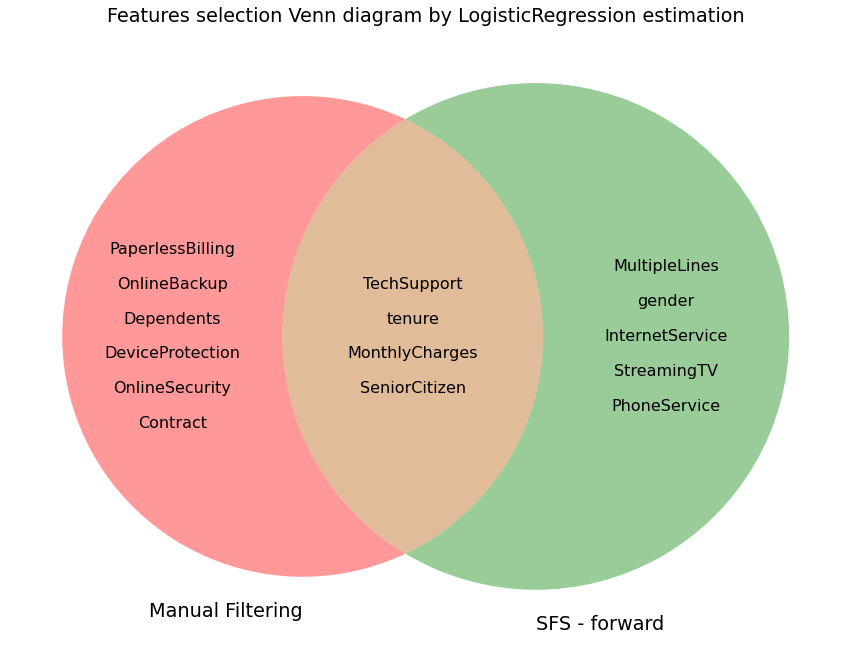

In [25]:
plot_selected_features(sfs_forward, df_for_estimation.drop(columns='Churn'))

We can see that less than half of the features we selected manually were also selected by the SFS forward process.
`Contract` was not selected automatically it is highly correlated with the label, probably since it is correlated to other features that were chosen like `TechSupport`.
`PaperlessBilling` was not chosen (surprisingly!) and we will check this feature significance in later stages when running XAI on model predictions

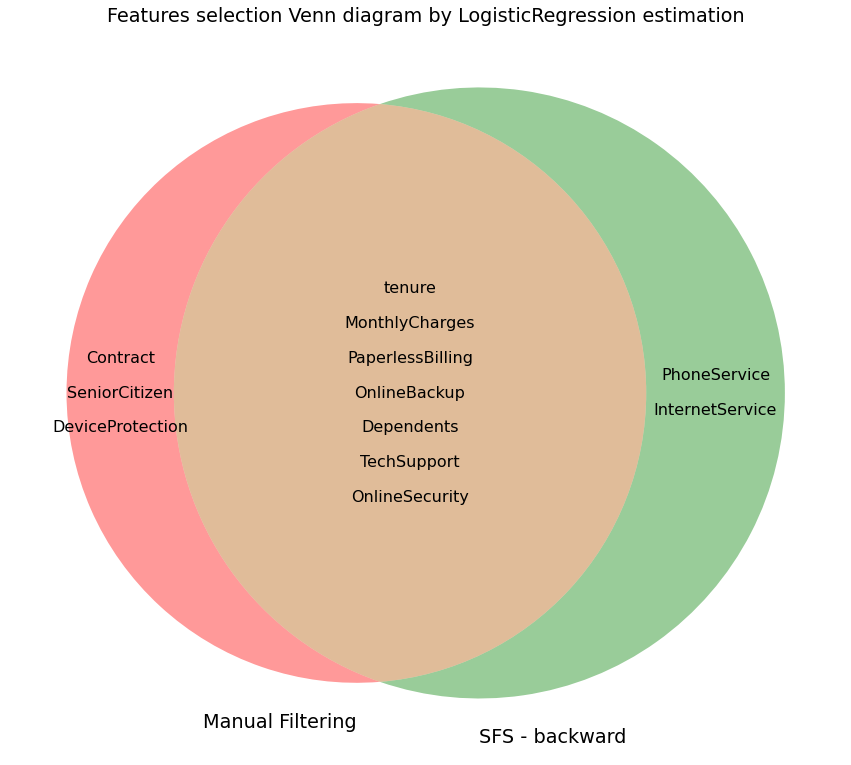

In [26]:
plot_selected_features(sfs_backward, df_for_estimation.drop(columns='Churn'))

We can see that most of the features we selected manually were also selected by the SFS backward process.
`Contract` was not selected automatically it is highly correlated with the label, probably since it is correlated to other features.
`PhoneService` and `InternetService` showed very low correlation with the label, and were probably chosen because they are less correlated with the other features.

#### SFS using a Decision Tree estimator

In [27]:
sfs_forward, sfs_backward = calc_SFS(X_train, y_train, DecisionTreeClassifier(random_state=RANDOM_STATE, criterion='entropy', min_samples_split=425, class_weight='balanced'))

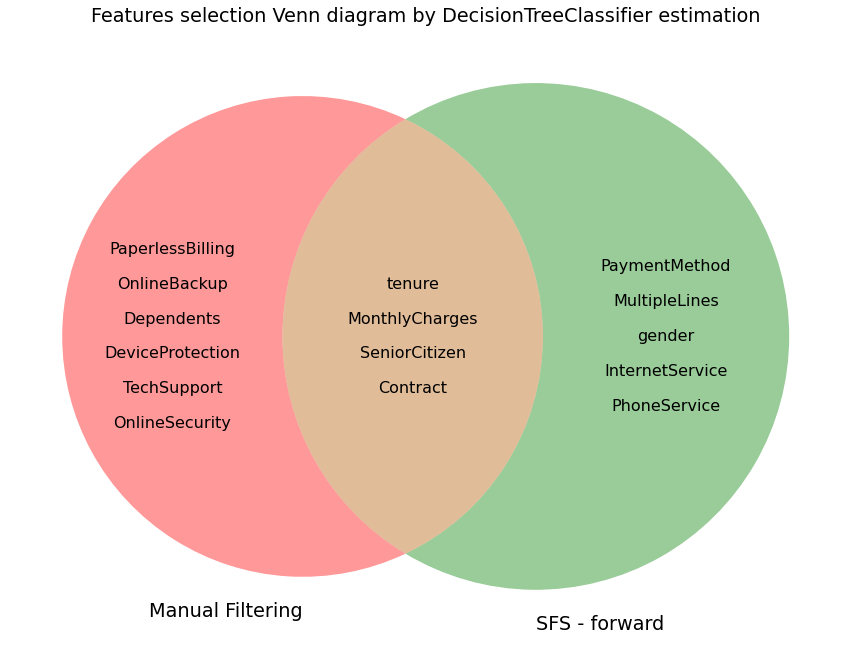

In [28]:
plot_selected_features(sfs_forward, df_for_estimation.drop(columns='Churn'))

We can see that less than half of the features we selected manually were also selected by the SFS forward process.
`TehcSopport` was not selected automatically although it is highly correlated with the label, probably since it is correlated to other features that were chosen like `Contract`.
`PaperlessBilling` was not chosen (surprisingly!) and we will check this feature significance in later stages when running XAI on model predictions

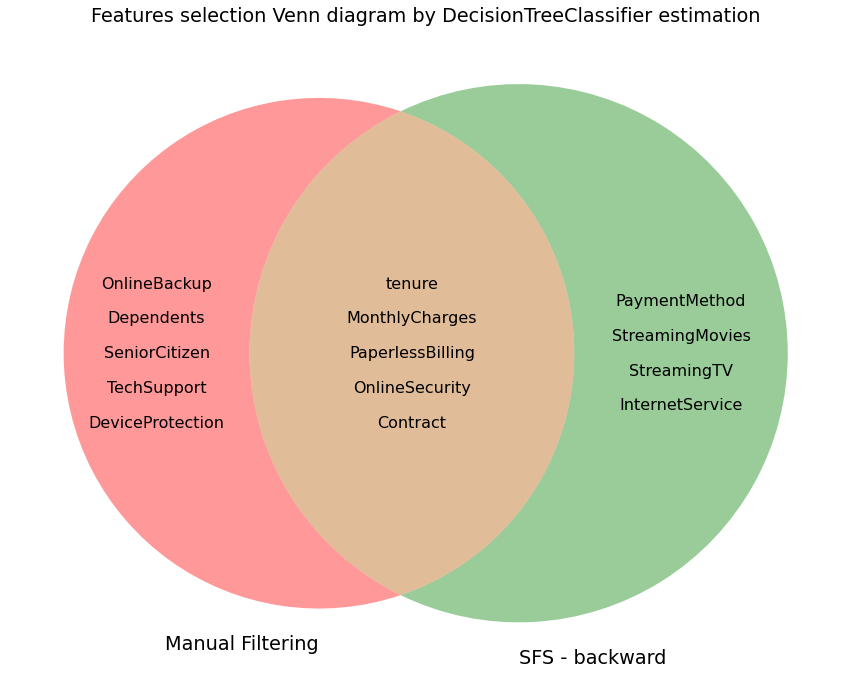

In [29]:
plot_selected_features(sfs_backward, df_for_estimation.drop(columns='Churn'))

We can see that half of the features we selected manually were also selected by the SFS backward process.
`TechSupport` was not selected automatically, although it is highly correlated with the label, probably since it is correlated to other features.
Looks like the algorithm chose to remove all the features the correlate to `Contract` thus is was left with only non-correlative to the label features like `StreamingTV` and `InternetService`

#### Automatic filtering using $\chi^2$ test

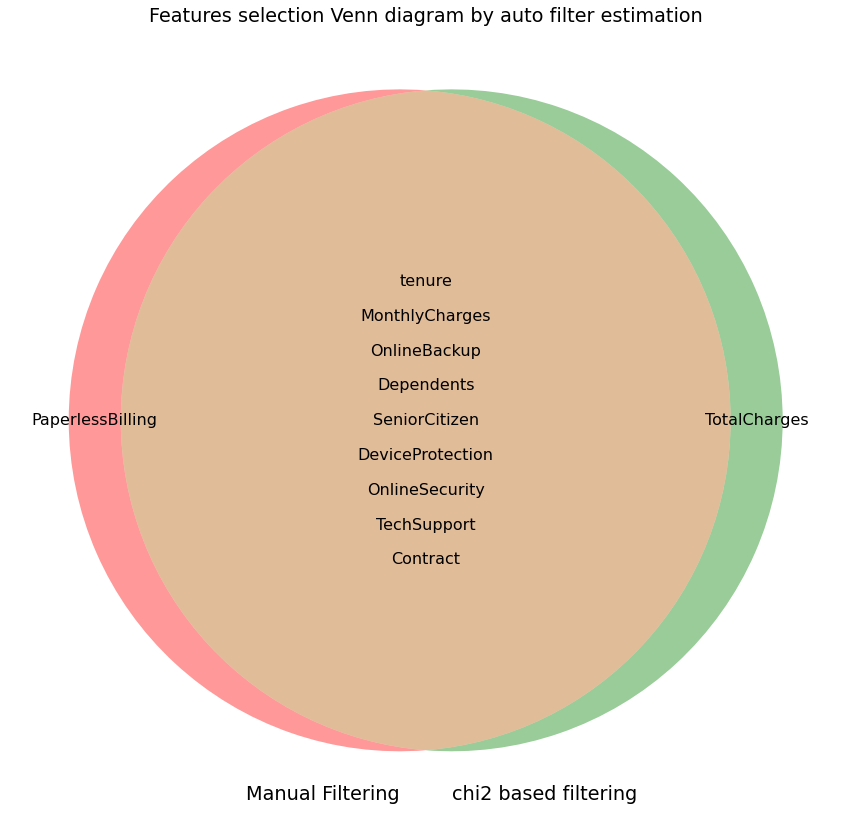

In [30]:
fs = SelectKBest(score_func=chi2, k=10).fit(X_train, y_train)
plot_selected_features(fs, df_for_estimation.drop(columns='Churn'), False)

We can see that the selected features are very close to the one selected manually, since correlation with the label is very evident in $\chi^2$ test

#### Automatic filtering using $I(Y;X):=MutualInformation(Y;X)$ test

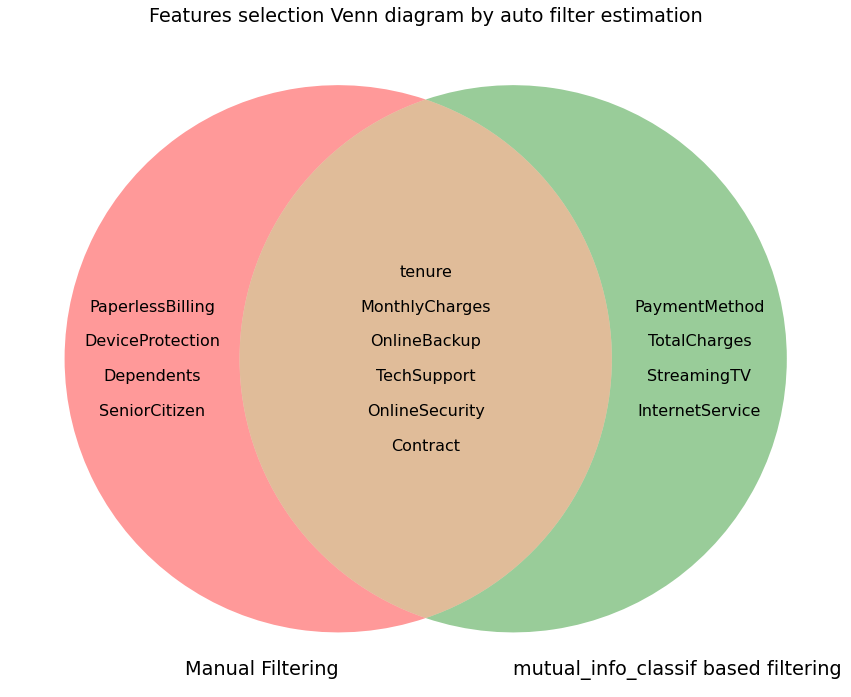

In [31]:
fs = SelectKBest(score_func=mutual_info_classif, k=10).fit(X_train, y_train)
plot_selected_features(fs, df_for_estimation.drop(columns='Churn'), False)

We see that a small amount of features differ from the manual selection, most likely due to inter-feature correlation we discussed previously.

## <center> Modeling

Since the samples are **imbalanced** with respect to the label, we would focus more on the churn `recall` metric, to guarantee no churners are missed by the model
(in expense of some degradation in the precision of our predictions for that population)

In [32]:
X = df_for_estimation.copy()
y = X.pop('Churn')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

In [33]:
def plot_norm_conf_matrix(fitted_model, X, y, normalize='true'):
    _, ax = plt.subplots(1, 1, figsize=(12, 7))
    ConfusionMatrixDisplay.from_estimator(estimator=fitted_model, X=X, y=y, normalize=normalize, ax=ax)
    ax.set(
        title=f'{fitted_model.__class__.__name__} test set confusion matrix\nnormalized over the {normalize} conditions')

In [34]:
def calc_metrics(fitted_model, X, y):
    metrics = precision_recall_fscore_support(y_true=y, y_pred=fitted_model.predict(X))
    return pd.DataFrame(metrics, index=['precision', 'recall', 'fscore', 'support'], columns=['Non-Churn', 'Churn']).T

#### Logistic Regression

In [35]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)
print(f'Logistic Regression score: {lr.score(X_test, y_test)}')

Logistic Regression score: 0.74739336492891


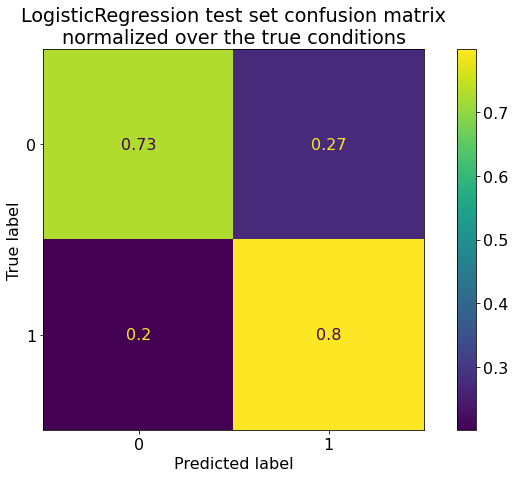

In [36]:
plot_norm_conf_matrix(lr, X_test, y_test)

In [37]:
calc_metrics(lr, X_test, y_test)

,precision,recall,fscore,support
Non-Churn,0.901961,0.727752,0.805545,1517.0
Churn,0.533860,0.797639,0.639621,593.0


#### Decision Tree

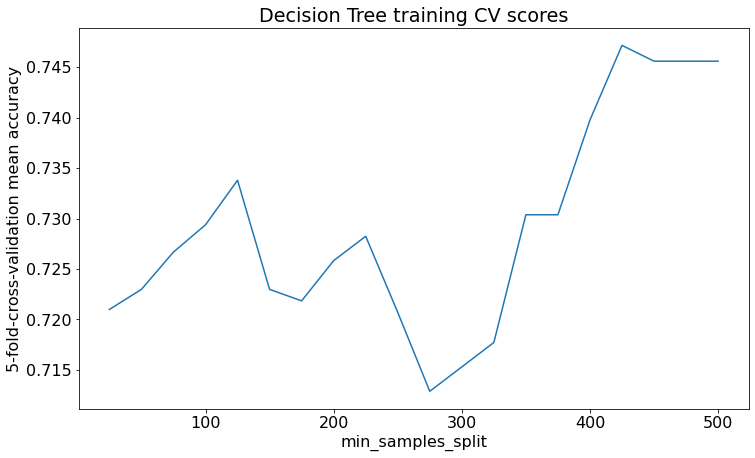

In [38]:
scores = np.zeros((20, 2))
for i in range(1, 21):
    min_samples_split = i * 25
    model = DecisionTreeClassifier(random_state=RANDOM_STATE, criterion='entropy', min_samples_split=min_samples_split, class_weight='balanced')
    scores[i-1] = (min_samples_split , np.mean(cross_val_score(model, X, y, cv=5)))
_, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.lineplot(y=scores[:, 1], x=scores[:, 0], ax=ax)
ax.set(title=f'Decision Tree training CV scores', xlabel='min_samples_split', ylabel=f'5-fold-cross-validation mean accuracy');

In [39]:
best_min_sample_split = scores[np.argmax(scores[:, 1]), 0].astype(int)

In [40]:
dt = DecisionTreeClassifier(min_samples_split=best_min_sample_split, criterion='entropy', class_weight='balanced')
dt.fit(X_train, y_train)
print(f'Decision Tree score: {dt.score(X_test, y_test)}')

Decision Tree score: 0.7483412322274882


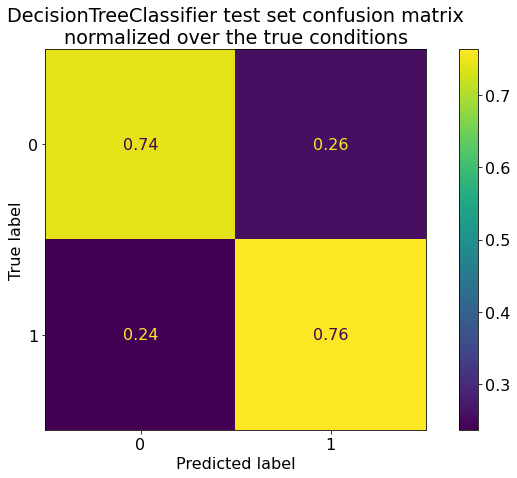

In [41]:
plot_norm_conf_matrix(dt, X_test, y_test)

In [42]:
calc_metrics(dt, X_test, y_test)

,precision,recall,fscore,support
Non-Churn,0.889415,0.742254,0.809199,1517.0
Churn,0.536730,0.763912,0.630480,593.0


#### Random Forest

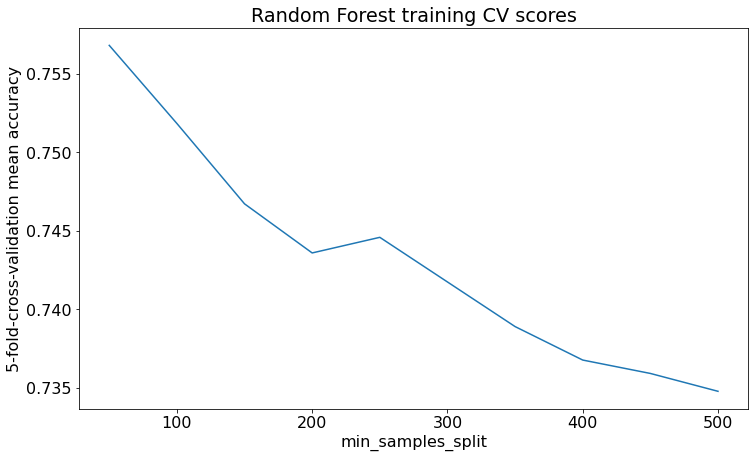

In [43]:
scores = np.zeros((10, 2))
for i in range(1, 11):
    min_samples_split = i * 50
    model = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', min_samples_split=min_samples_split, random_state=RANDOM_STATE)
    scores[i-1] = (min_samples_split , np.mean(cross_val_score(model, X, y, cv=5)))
_, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.lineplot(y=scores[:, 1], x=scores[:, 0], ax=ax)
ax.set(title=f'Random Forest training CV scores', xlabel='min_samples_split', ylabel=f'5-fold-cross-validation mean accuracy');

In [44]:
best_min_sample_split = scores[np.argmax(scores[:, 1]), 0].astype(int)
best_min_sample_split

50

In [45]:
rf = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', min_samples_split=best_min_sample_split)
rf.fit(X_train, y_train)
print(f'Random Forest score: {rf.score(X_test, y_test)}')

Random Forest score: 0.7663507109004739


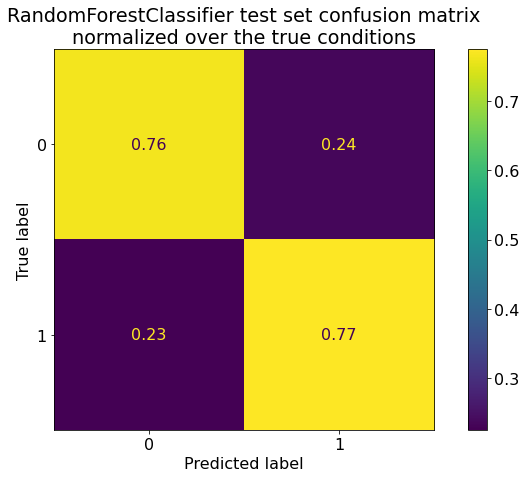

In [46]:
plot_norm_conf_matrix(rf, X_test, y_test)

In [47]:
calc_metrics(rf, X_test, y_test)

,precision,recall,fscore,support
Non-Churn,0.896285,0.763349,0.824493,1517.0
Churn,0.561125,0.774030,0.650602,593.0


## <center> Explainable AI

In [48]:
plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams['font.size'] = 12

In [49]:
cat_cols_idx = [0,1,3,4,5,6,7,8]

In [50]:
def get_lime_explanation(instance_id, estimator):
    class_names = ['Non-Churn', 'Churn']

    explainer = lime_tabular.LimeTabularExplainer(
        training_data=X_train.values,
        training_labels=y_train,
        categorical_features=cat_cols_idx,
        class_names=class_names,
        feature_names=X_train.columns,
    )
    exp = explainer.explain_instance(X_test.iloc[instance_id], estimator.predict_proba)

    print(f'Test Sample id: {instance_id}')
    print('Probability(Churn) =', estimator.predict_proba([X_test.iloc[instance_id]])[0,1])
    print('True class: %s' % class_names[y_test.iloc[instance_id]])
    return exp

In [51]:
shap.initjs()

def get_shap_values(instance_id, estimator):
    explainer = shap.KernelExplainer(estimator.predict_proba, shap.sample(X_train, 100, random_state=RANDOM_STATE))
    shap_values = explainer.shap_values(X_test.iloc[instance_id])
    return explainer.expected_value[1], shap_values[1]

### Logistic Regression


**Global Model based features importance ranking**

We calculate the feature importance by multiplying the coefficients of each feature with its standard deviation
We can see that as expected with our EDA, `tenure`, `MonthlyCharges` and `Contract` seem to be the most important features for this model


In [52]:
features_magnitude = np.abs(np.std(X_train, 0) * lr.coef_[0, :])
sorted_idx = np.argsort(features_magnitude, axis=0)[::-1]
print('Logistic Regression feature importance:\n')
print(features_magnitude[sorted_idx])

Logistic Regression feature importance:

tenure              0.800001
MonthlyCharges      0.769906
Contract            0.630976
OnlineSecurity      0.203577
TechSupport         0.169897
PaperlessBilling    0.164811
SeniorCitizen       0.099223
Dependents          0.096327
OnlineBackup        0.035462
DeviceProtection    0.028723
dtype: float64


**Local explanation of a true positive sample based on LIME & SHAP**

Here we looked for the **local** explanation based on LIME & SHAP of a true-positive prediction.
We are mostly interested in high recall of the `Churn=1` population, so this measure of precision is important

We can see that like the **global** explanation, the top 3 features with largest magnitude are `tenure`, `MonthlyCharges` and `Contract`
although their order changed a bit.
The Magnitude of the feature importance changed though.

Both LIME and SHAP seem to agree on most of the features.

Overall this seems pretty much in correlation with the global explanation, and this makes sense, since the explained model is linear as well, just like the model fitted in the vicinity of the tested sample during LIME algorithm.
Since the probability for `Churn=1` is high for this sample, we understand that the sample lies deep into the confidence interval of the sample space that are classified as `Churn`

Test Sample id: 101
Probability(Churn) = 0.8150356135775008
True class: Churn


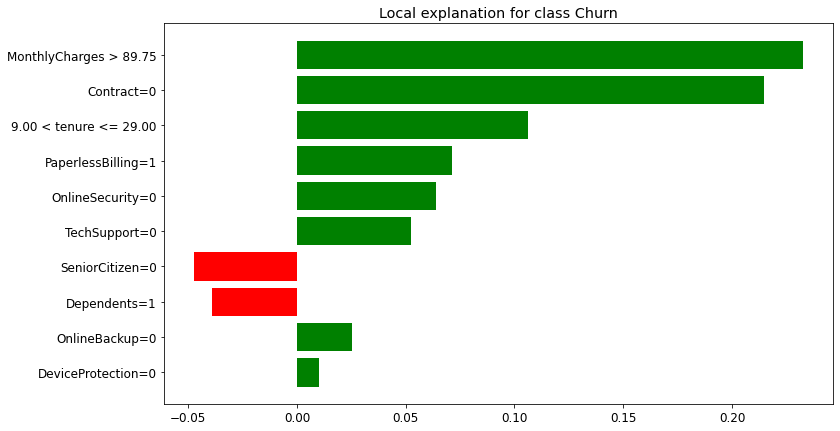

In [53]:
get_lime_explanation(101, lr).as_pyplot_figure();

In [54]:
instance_id = 101
expected_value, shap_values = get_shap_values(instance_id, lr)
print(f'Shap values of features in prediction of test sample {instance_id}')
shap.force_plot(expected_value, shap_values, X_test.iloc[instance_id])

Shap values of features in prediction of test sample 101


**Local explanation of a false negative sample based on LIME & SHAP**

In this case we looked at a false-negative sample from the test set (a churner we missed)
It is interesting to see, that the top 3 features remain the same as in the previous global and local explanation of other samples,
here, 2 of these features have negative effect on the label in the sample vicinity, according to the range of the features.
Meaning that the model probably generalized these features range otherwise, so the prediction is wrong.

Again, LIME and SHAP mostly agree on the features order and magnitude, although there are some differences (i.e.: in the `TechSupport` feature)


Test Sample id: 4
Probability(Churn) = 0.3477124773744925
True class: Churn


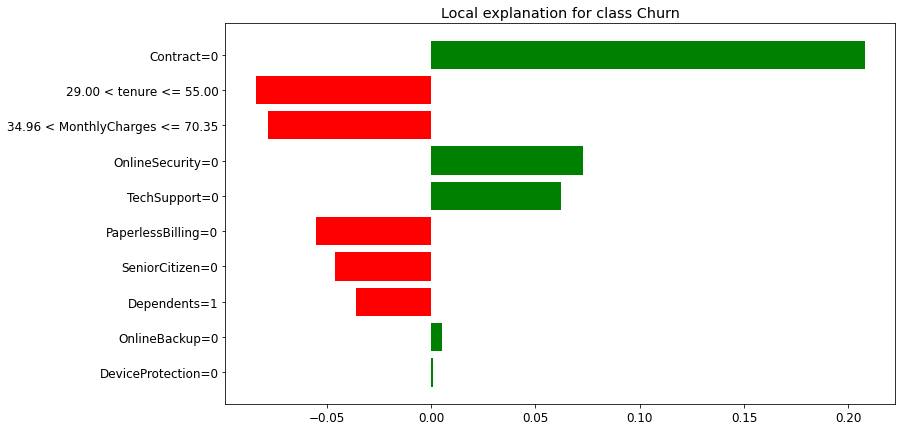

In [55]:
get_lime_explanation(4, lr).as_pyplot_figure();

In [56]:
lr.predict_proba(np.column_stack(X_test.iloc[4].values))

array([[0.65228752, 0.34771248]])

In [57]:
instance_id = 4
expected_value, shap_values = get_shap_values(instance_id, lr)
print(f'Shap values of features in prediction of test sample {instance_id}')
shap.force_plot(expected_value, shap_values, X_test.iloc[instance_id])

Shap values of features in prediction of test sample 4


### Decision Tree

**Global Model based features importance ranking**

We calculate the feature importance looking and the nodes of the tree and using the order of split (1st feature to split by, had the largest information gain and so on)
Since we ran our tree with a ~400 min_sample_split limitation, not all features were selected during the training process.
Surprisingly, `Contract` feature has a much higher importance than the other 2 features that are part of the top-3, yet the same 4 features were chosen like in the logistic regression model

In [58]:
dt_feature_importance = np.column_stack([X.columns, dt.feature_importances_])
dt_feature_importance[np.argsort(dt_feature_importance[:, 1])[::-1], :]

array([['Contract', 0.6133330925637397],
       ['MonthlyCharges', 0.18342484014538932],
       ['tenure', 0.11697919365106856],
       ['OnlineSecurity', 0.08626287363980227],
       ['PaperlessBilling', 0.0],
       ['TechSupport', 0.0],
       ['DeviceProtection', 0.0],
       ['OnlineBackup', 0.0],
       ['Dependents', 0.0],
       ['SeniorCitizen', 0.0]], dtype=object)

**Local explanation of a true positive sample based on LIME & SHAP**

Here we looked for the **local** explanation based on LIME/SHAP of a true-positive prediction.
We are mostly interested in high recall of the `Churn=1` population, so this measure of precision is important

We can see that like the unlike the **global** explanation, the top 3 features with largest magnitude are `OnlineSecurity`, `MonthlyCharges` and `Contract` (`tenure` is down in the list)
This is really surprising! The `tenure` feature that seemed very important in the EDA, looks less important in the vicinity of the test sample.
The probability of the model's prediction also reduced in comparison to the logistic regression model.

Generally, we see less correlation between the decision tree model and the local LIME/SHAP explanation than the one we saw in the logistic regression model

Test Sample id: 101
Probability(Churn) = 0.6001148217497674
True class: Churn


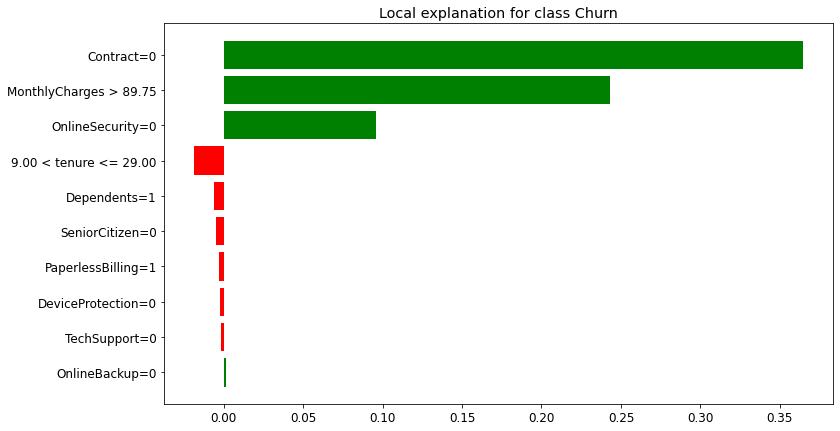

In [59]:
get_lime_explanation(101, dt).as_pyplot_figure();

In [60]:
instance_id = 101
expected_value, shap_values = get_shap_values(instance_id, dt)
print(f'Shap values of features in prediction of test sample {instance_id}')
shap.force_plot(expected_value, shap_values, X_test.iloc[instance_id])

Shap values of features in prediction of test sample 101


**Local explanation of a false negative sample based on LIME & SHAP**

In this case we looked at a false-negative sample from the test set (a churner we missed)
It is interesting to see, that the top 4 features remain the same as in the previous local explanation of other samples (yet different than the global explanation),
here, 2 of these features have negative effect on the label in the sample vicinity, according to the range of the features.
Meaning that the model probably generalized these features range otherwise, so the prediction is wrong

Test Sample id: 4
Probability(Churn) = 0.44898676273073207
True class: Churn


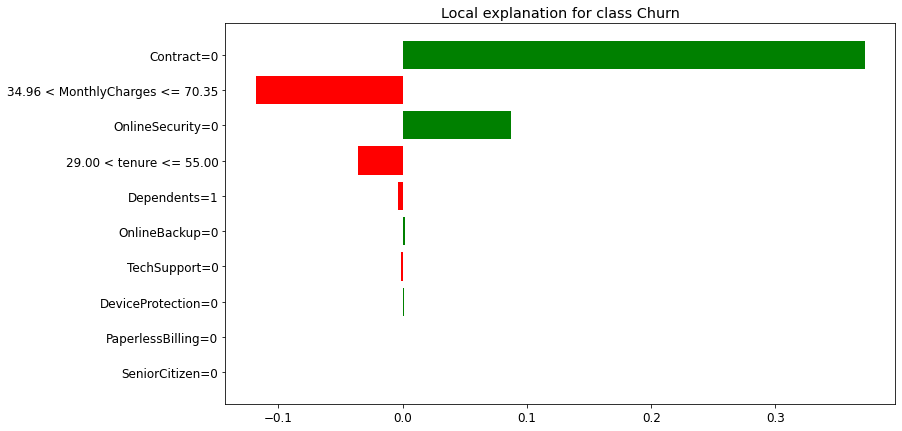

In [61]:
get_lime_explanation(4, dt).as_pyplot_figure();

In [62]:
instance_id = 4
expected_value, shap_values = get_shap_values(instance_id, dt)
print(f'Shap values of features in prediction of test sample {instance_id}')
shap.force_plot(expected_value, shap_values, X_test.iloc[instance_id])

Shap values of features in prediction of test sample 4


### Random Forest

**Global Model based features importance ranking**

We calculate the impurity-based feature importance, generated by shuffling each feature values and calculation the OOB error of the ensemble model.
The importances we see are similar to the correlation to the label we saw during the EDA (unlike the decision tree model where only one tree was build, and not all feature were used)

In [63]:
rf_feature_importance = np.column_stack([X.columns, rf.feature_importances_])
rf_feature_importance[np.argsort(rf_feature_importance[:, 1])[::-1], :]

array([['Contract', 0.2809869518454277],
       ['tenure', 0.2353307069034713],
       ['MonthlyCharges', 0.20222652134951744],
       ['OnlineSecurity', 0.10358043988978162],
       ['TechSupport', 0.06667393810935769],
       ['OnlineBackup', 0.034569667638397264],
       ['PaperlessBilling', 0.024641049039274877],
       ['DeviceProtection', 0.023092144703188554],
       ['SeniorCitizen', 0.015205088961446225],
       ['Dependents', 0.013693491560137303]], dtype=object)

**Local explanation of a true positive sample based on LIME & SHAP**

Here we looked for the **local** explanation based on LIME/SHAP of a true-positive prediction.
We are mostly interested in high recall of the `Churn=1` population, so this measure of precision is important

We can see that unlike the **global** explanation, the `tenure` feature that seemed very important in the EDA, looks less important in the vicinity of the test sample.
Other than that, the local explanation correlates with the global (model-based) one

SHAP and LIME agree on most of the features

Test Sample id: 101
Probability(Churn) = 0.7107795451508521
True class: Churn


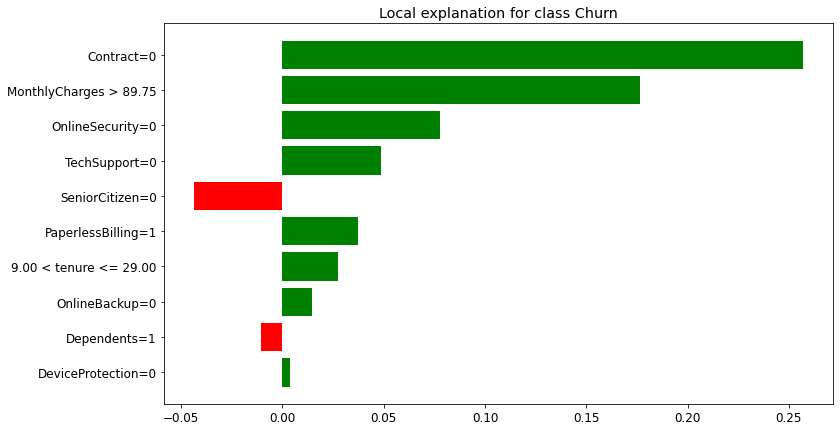

In [64]:
get_lime_explanation(101, rf).as_pyplot_figure();

In [65]:
instance_id = 101
expected_value, shap_values = get_shap_values(instance_id, rf)
print(f'Shap values of features in prediction of test sample {instance_id}')
shap.force_plot(expected_value, shap_values, X_test.iloc[instance_id])

Shap values of features in prediction of test sample 101


**Local explanation of a false negative sample based on LIME & SHAP**

In this case we looked at a false-negative sample from the test set (a churner we missed)

It is interesting to see, that probably what caused this sample to be labeled as `Non-Churn` is the `MonthlyCharges` value, that was in a range that the model caught as indicative to a `Non-Churner`
The median of the feature for the `Non-Churner` population is ~60 so this makes sense.
This person also seems to have a high `tenure` value (amount of time being customer of the company) and this also gives us some explanation of why the model was wrong on this one.


Test Sample id: 4
Probability(Churn) = 0.394852066325705
True class: Churn


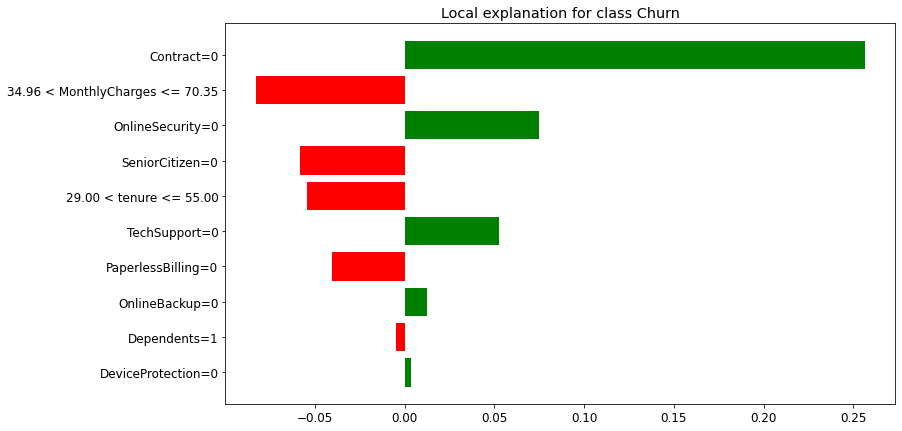

In [66]:
get_lime_explanation(4, rf).as_pyplot_figure();

In [67]:
instance_id = 4
expected_value, shap_values = get_shap_values(instance_id, rf)
print(f'Shap values of features in prediction of test sample {instance_id}')
shap.force_plot(expected_value, shap_values, X_test.iloc[instance_id])

Shap values of features in prediction of test sample 4


# Summary

In this report we examined several method for feature selection and explainable AI
We used the "Telco-Churn" dataset to train a Churn prediction model based on the ~7000 samples and 20 features in the dataset

In **feature selection** we compared manual selection based on correlation values and statistical analysis of feature significance, to Sequential Feature Selection (both backwards and forwards)
We saw that most features were selected in all methods, but some features we're different, probably due to SFS being a greedy algorythm.

Then, we train 3 model architectures, **Logistic Regression, Decision Tree** and **Random Forest**
We chose 2 samples from the test set, 1 *true-positive* and 1 *false-negative*, to examine how the trained model perform when encountering an actual `Churn` sample (the `Non-Churn` case was less interesting to us)
Then, we explored the explainable of the 2 predictions for those samples using 3 methods:
* In model **global** feature importance
* LIME **local** prediction explanation
* SHAP **local** prediction explanation

We described the similarities and differences between the global / local explanations, and used the local explanation to understand when and why our model is correct / incorrect